# Setting up Fast Hyperparameter Search Framework with Pyspark

In this notebook, we set up hyperparameter tuning framework in PySpark using machine learning libraries like scikit-learn/xgboost/lightgbm 

Manual tuning has to change a lot of parameters. Hyperopt works only one model at a time. So it was taking up a lot of time to train each model and I was pretty short on time.

But can we parallelize my model hyperparameter search process?

You can choose to load your data using Spark, but here I start by creating our own classification data to set up a minimal example which we can work with.

In [1]:
#we use the findspark library to locate spark on our local machine
import findspark
findspark.init('C:/Users/bokhy/spark/spark-2.4.6-bin-hadoop2.7')

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import datasets

import random
import os
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import time
from IPython.display import Image

import pyspark # only run this after findspark.init()
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import SparkSession, SQLContext
from pyspark.context import SparkContext

## Load Spark Session

In [3]:
spark = SparkSession.builder.appName('hyper-tuning').getOrCreate()

In [4]:
spark

In [16]:
X,y = datasets.make_classification(n_samples=100, 
                                   n_features=4, 
                                   n_informative=2, 
                                   n_classes=2, 
                                   random_state=623,
                                   shuffle=True)

In [17]:
train = pd.DataFrame(X)
train['target'] = y

In [18]:
train_sp = spark.createDataFrame(train)

In [19]:
train_sp = train_sp.toDF(*['c0', 'c1', 'c2', 'c3', 'target'])

In [20]:
train_sp.show()

+--------------------+--------------------+--------------------+--------------------+------+
|                  c0|                  c1|                  c2|                  c3|target|
+--------------------+--------------------+--------------------+--------------------+------+
| 0.32012361672251677| -0.4253715175371259|-0.19057549039497973|-0.14928231355839838|     0|
| 0.33500090238265867| -0.5684299153776691|  0.7924806821551242| -1.2779690995202135|     0|
| -0.7794082941605487|   0.864449299755419|  1.8414214193177343| -1.1942638608472032|     0|
| -2.3459013184814097|  2.8848422500426705|  3.2657182909604896| -1.0198659288295877|     0|
|-0.20483169280564287|  0.3952384975068274| -0.8681535296084092|  1.2152102540355667|     1|
| 0.37712043827263486| -0.4000407378242594| -1.0376251786761053|  0.7436899038043132|     1|
| -0.9923250730977524|  1.3755987312890325| 0.13196783924883856|  0.9815817381027226|     1|
|  -1.700715223234123|  2.0611308363108085|   2.611348894738913|  -1.0

So now we have got our training dataset in Spark. And we want to run multiple models on this DataFrame.

We replicate our data n times and add a replication_id to our data so that each key has all the data.

Ok, now we can send the whole data to multiple machines using groupby on replication_id. But how do we use pandas and scikit learn on that data?

The answer is: we use pandas_udf. This functionality was introduced in the Spark version 2.3.1. And this allows you to utilise pandas functionality with Spark.

## Replicate the Dataset n times

In [21]:
# replicate the spark dataframe into multiple copies
replication_df = spark.createDataFrame(pd.DataFrame(list(range(1,100)),columns=['replication_id']))

In [22]:
replicated_train_df = train_sp.crossJoin(replication_df)

In [23]:
replicated_train_df.show()

+-------------------+-------------------+--------------------+--------------------+------+--------------+
|                 c0|                 c1|                  c2|                  c3|target|replication_id|
+-------------------+-------------------+--------------------+--------------------+------+--------------+
|0.32012361672251677|-0.4253715175371259|-0.19057549039497973|-0.14928231355839838|     0|             1|
|0.32012361672251677|-0.4253715175371259|-0.19057549039497973|-0.14928231355839838|     0|             2|
|0.32012361672251677|-0.4253715175371259|-0.19057549039497973|-0.14928231355839838|     0|             3|
|0.32012361672251677|-0.4253715175371259|-0.19057549039497973|-0.14928231355839838|     0|             4|
|0.32012361672251677|-0.4253715175371259|-0.19057549039497973|-0.14928231355839838|     0|             5|
|0.32012361672251677|-0.4253715175371259|-0.19057549039497973|-0.14928231355839838|     0|             6|
|0.32012361672251677|-0.4253715175371259|-0.19

We also define a function that takes as input a pandas dataframe, gets random hyperparameters using the python random module, runs a model on data(Here I am training a scikit model, but you can replace it with any model like XGBoost or Lightgbm as well) and returns the result in the form of a Pandas Dataframe. Do take a look at the function and the comments.

In [24]:
# 0. Declare the schema for the output of our function
outSchema = StructType([StructField('replication_id',IntegerType(),True),
                        StructField('Accuracy',DoubleType(),True),
                        StructField('num_trees',IntegerType(),True),
                        StructField('depth',IntegerType(),True),
                        StructField('criterion',StringType(),True)])

# decorate our function with pandas_udf decorator
@F.pandas_udf(outSchema, F.PandasUDFType.GROUPED_MAP)
def run_model(pdf):
    # 1. Get hyperparam values
    num_trees =  random.choice(list(range(50,500)))
    depth = random.choice(list(range(2,10)))
    criterion = random.choice(['gini','entropy'])
    replication_id = pdf.replication_id.values[0]
    # 2. Train test split
    X = pdf[['c0', 'c1', 'c2', 'c3']]
    y = pdf['target']
    #del X['target']
    Xtrain,Xcv,ytrain,ycv = train_test_split(X, y, test_size=0.3, random_state=42)
    # 3. Create model using the pandas dataframe
    clf = RandomForestClassifier(n_estimators=num_trees, max_depth = depth, criterion =criterion)
    clf.fit(Xtrain,ytrain)
    # 4. Evaluate the model
    accuracy = accuracy_score(clf.predict(Xcv),ycv)
    # 5. return results as pandas DF
    res =pd.DataFrame({'replication_id':replication_id,'Accuracy':accuracy, 'num_trees':num_trees,'depth':depth,'criterion':criterion}, index=[0])
    return res

## We first replicate our train dataframe 100 times here by using cross_join with a data frame that contains a column with 1–100 replication_id.

In [27]:
results = replicated_train_df.groupby("replication_id").apply(run_model)

What the above code does is that it sends all the data with the same replication id to a single machine and applies the function run_model to the data. The above call happens lazily so you won’t be able to see the results till you run the below action call.

In [ ]:
results.sort(F.desc("Accuracy")).show()

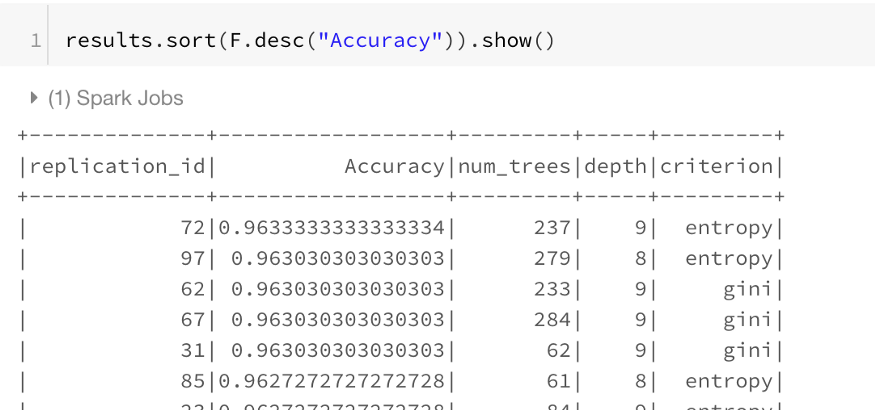

In [31]:
file_name1 = './img/hyper.png'
Image(file_name1)

#### For this toy example, the accuracy results may look pretty close to one another, but they will differ in the case of noisy real-world datasets. Since all of these 100 models run in parallel on different nodes, we can save a lot of time when doing random hyperparameter search